In [13]:
import pandas as pd
from IPython.display import clear_output

clear_output()

In [14]:
# population get

Population_file_path = 'Distance_for_nn.xlsx'
population = pd.read_excel(Population_file_path, sheet_name='Population_quart')
population = list(population.Population)

number_of_quarts = len(population)

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


In [15]:
# market data get

Markets_file_path = 'Market_data_for_nn.xlsx'  # 21 is best for MAE - 25000epochs, 41 for MAPE - 8000epochs
market_data = pd.read_excel(Markets_file_path, index_col='Full_Address')

Coord_file_path = 'Coord_for_nn.xlsx'
coord = pd.read_excel(Coord_file_path, index_col='Full_Address')

market_data = market_data.join(coord)

market_data = market_data.reset_index()
market_data.head()

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [16]:
# get Huff for training dataset

import huff_and_map

huff_pred = []

for index,row in market_data.iterrows():
    huff = huff_and_map.calculate_huff(row['lon'], row['lat'], row['Square'])
    huff_pred.append(huff)

In [17]:
# Huff insertion in DataFrame

market_data.insert(0, 'Huff', huff_pred)
market_data.head()

,Huff,Full_Address,Type,Square,Categorical_Brand,Traffic,Time,Building_Type,Frequency,Id,lat,lon
0,356.022102,1 Новосмоленская набережная Санкт-Петербург,магазин,126.0,Другие,4586,51,жилой дом,89.921569,118,30.230887,59.949145
1,292.059226,100 Средний проспект В.О. Санкт-Петербург,магазин,131.0,Другие,4339,31,жилой дом,139.967742,152,30.241092,59.931648
2,765.360307,11 ул. Нахимова Санкт-Петербург,супермаркет,295.0,Пятерочка,26854,39,жилой дом,688.564103,138,30.222111,59.941042
3,251.443887,12В 17-я линия Васильевского острова Санкт-Пет...,супермаркет,253.7,Пятерочка,22610,31,жилой дом,729.354839,120,30.270979,59.934799
4,254.425867,13/46 16-я Линия Санкт-Петербург,супермаркет,251.0,ВкусВилл,18190,32,жилой дом,568.437500,122,30.271339,59.935196


In [18]:
# Features and Target

X = market_data
y = market_data['Frequency']
X = X.drop(['Frequency'], axis=1)

X = X.drop(['Full_Address'], axis=1)
#X = X.drop(['Square'], axis=1)
#X = X.drop(['Huff'], axis=1)
X = X.drop(['Traffic'], axis=1)
X = X.drop(['Time'], axis=1)
X = X.drop(['Id'], axis=1)
X = X.drop(['lat'], axis=1)
X = X.drop(['lon'], axis=1)
#X = X.drop(['Type'], axis=1)
#X = X.drop(['Categorical_Brand'], axis=1)
#X = X.drop(['Building_Type'], axis=1)

In [19]:






# MODEL PART







In [20]:
# X - pandas dataframe with features, y - pandas dataframe with targets

categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

X.head()

,Huff,Type,Square,Categorical_Brand,Building_Type
0,356.022102,магазин,126.0,Другие,жилой дом
1,292.059226,магазин,131.0,Другие,жилой дом
2,765.360307,супермаркет,295.0,Пятерочка,жилой дом
3,251.443887,супермаркет,253.7,Пятерочка,жилой дом
4,254.425867,супермаркет,251.0,ВкусВилл,жилой дом


In [21]:
# One-hot encoding

X = pd.get_dummies(X, columns=categorical_cols)

In [22]:
# Model

import torch
from torch import nn
from torch.nn import MSELoss, L1Loss
from torchmetrics import MeanAbsolutePercentageError

torch.manual_seed(17)

class NeuralNetwork(torch.nn.Module):

    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(len(X.columns), 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred


In [36]:
m_model = NeuralNetwork()
optimizer_ln = torch.optim.Adam(m_model.parameters(), lr=0.008)

# choose loss
loss_l1 = L1Loss()
loss_mse = MSELoss()
loss_mape = MeanAbsolutePercentageError()
loss = loss_l1

In [37]:
# model training

from torch.autograd import Variable

x_data_all = Variable(torch.Tensor(X.values))
y_data_all = Variable(torch.Tensor([[target] for target in y.values]))
for epoch in range(20001):
    pred_y = m_model(x_data_all)
    loss_ln = loss(pred_y, y_data_all)

    optimizer_ln.zero_grad()
    loss_ln.backward()
    optimizer_ln.step()

In [38]:
#saving model

torch.save(m_model.state_dict(), 'model')

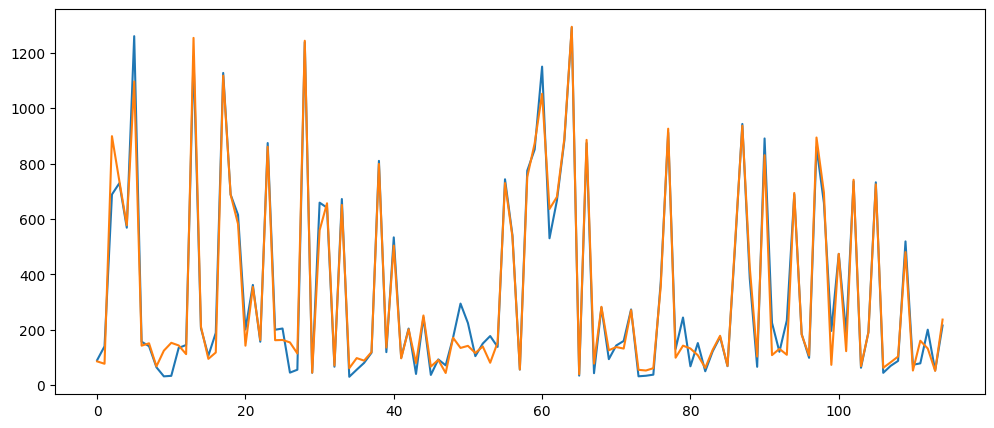

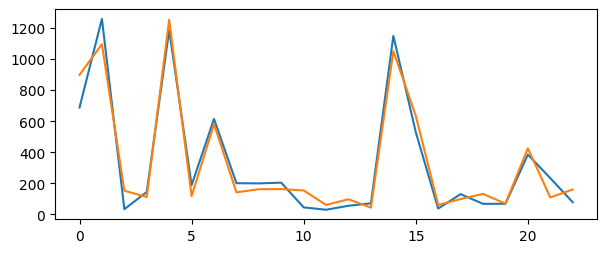

70.22767639160156
all data: 33.05450439453125
/


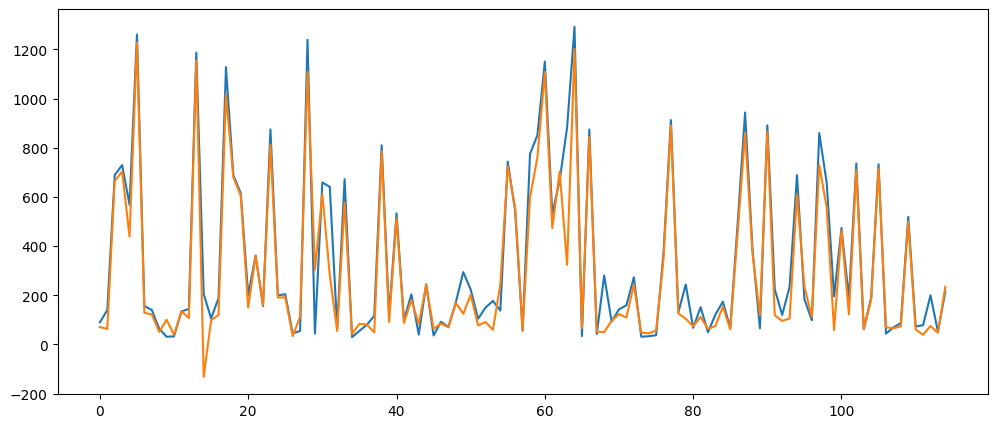

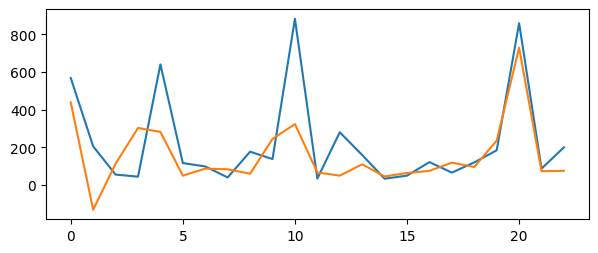

122.94610595703125
all data: 54.01020431518555
/


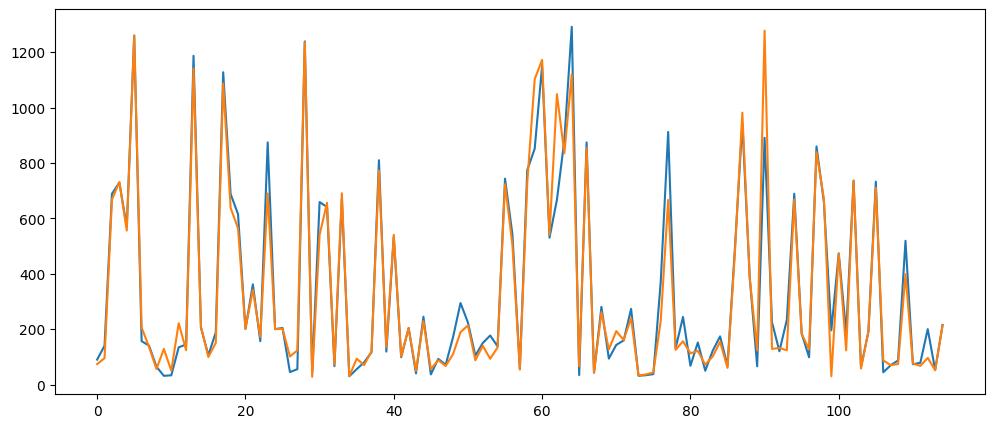

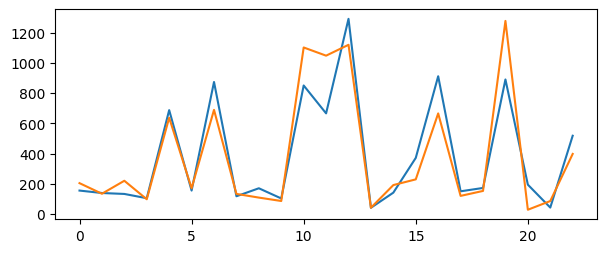

108.69169616699219
all data: 41.56419372558594
/


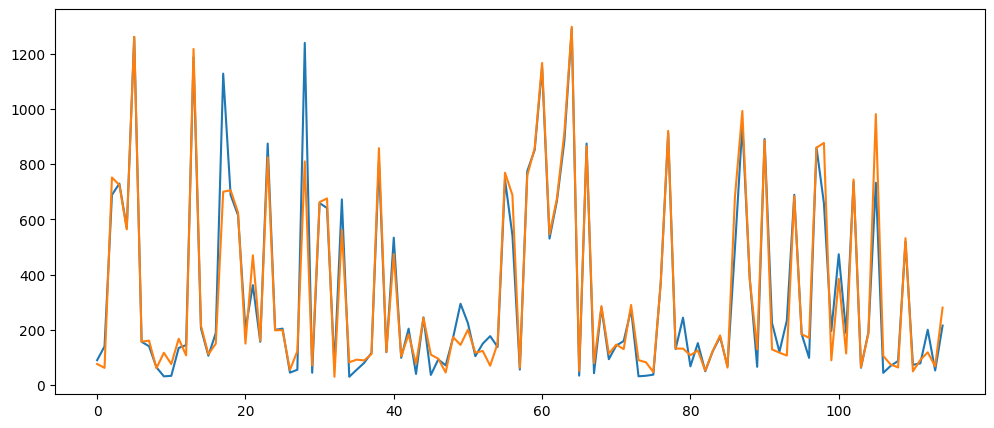

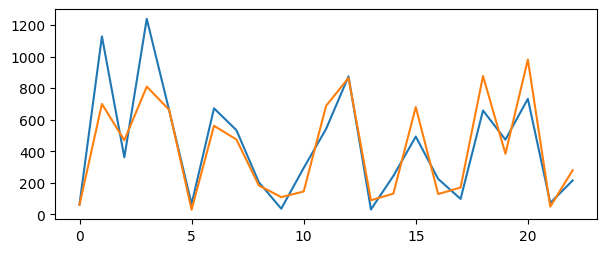

119.39754486083984
all data: 43.18281173706055
/


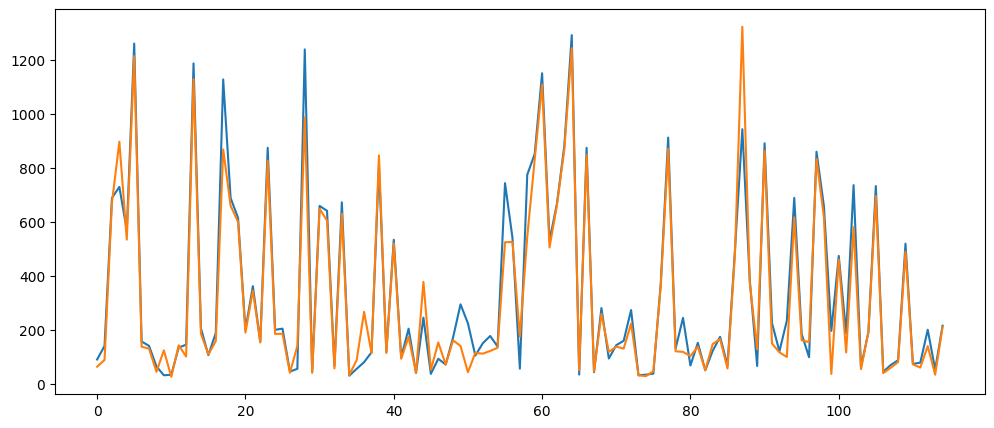

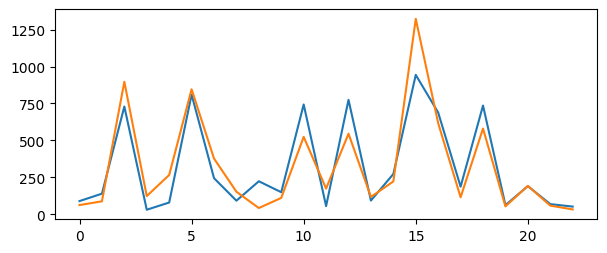

101.42752075195312
all data: 45.5395393371582
/
valid data mean: 104.5381088256836
all data mean: 43.4702507019043


In [39]:
# train test and cross-validation, if needed

from sklearn.model_selection import KFold
from torch.autograd import Variable


kf = KFold(n_splits=5, random_state=4, shuffle=True)

metrics_valid = []
metrics_all = []

x_data_all = Variable(torch.Tensor(X.values))
y_data_all = Variable(torch.Tensor([[target] for target in y.values]))

for train_ind, test_ind in kf.split(X):

    x_data_train = Variable(torch.Tensor(X.values[train_ind]))
    y_data_train = Variable(torch.Tensor([[target] for target in y.values[train_ind]]))

    x_data_valid = Variable(torch.Tensor(X.values[test_ind]))
    y_data_valid = Variable(torch.Tensor([[target] for target in y.values[test_ind]]))

    m_model = NeuralNetwork()

    optimizer_ln = torch.optim.Adam(m_model.parameters(), lr=0.008)

    for epoch in range(8001):
        pred_y = m_model(x_data_train)
        loss_ln = loss(pred_y, y_data_train)

        optimizer_ln.zero_grad()
        loss_ln.backward()
        optimizer_ln.step()


    m_predictions = m_model(x_data_valid)
    m_predictions_all = m_model(x_data_all)

    import matplotlib.pyplot as plt
    fig1 = plt.figure(figsize=(12, 5))
    fig2 = plt.figure(figsize=(7, 6))
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(211)

    ax1.plot(list(i for i in range(len(y))), list(y))
    ax1.plot(list(i for i in range(len(y))), m_predictions_all.tolist())
    ax2.plot(list(i for i in range(len(y_data_valid.tolist()))), list(y_data_valid.tolist()))
    ax2.plot(list(i for i in range(len(y_data_valid.tolist()))), m_predictions.tolist())
    plt.show()

    loss_valid = loss(m_predictions, y_data_valid)
    loss_all = loss(m_predictions_all, y_data_all)
    metrics_valid.append(loss_valid.item())
    metrics_all.append(loss_all.item())

    print(loss_valid.item())
    print('all data:', loss_all.item())
    print('/')

from statistics import mean

print('valid data mean:', mean(metrics_valid))
print('all data mean:', mean(metrics_all))